<a href="https://colab.research.google.com/github/BenjaminDKLuong/Colab_Notes/blob/master/Stock_Price_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Predict

In [1]:
!git clone https://github.com/PacktPublishing/Real-World-Python-Deep-Learning-Projects.git

Cloning into 'Real-World-Python-Deep-Learning-Projects'...
remote: Enumerating objects: 13503, done.
remote: Total 13503 (delta 0), reused 0 (delta 0), pack-reused 13503
Receiving objects: 100% (13503/13503), 178.97 MiB | 34.62 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Checking out files: 100% (13472/13472), done.


In [0]:
# change working directory to new location
import os
os.chdir("/content/Real-World-Python-Deep-Learning-Projects/Section 5 Code/source")


In [3]:
# check current working directory
%pwd

'/content/Real-World-Python-Deep-Learning-Projects/Section 5 Code/source'

## Data Process

In [0]:
import pandas
import numpy as np
from matplotlib import pyplot

def get_raw_xy(data):
    data=data.drop(columns=['Date','Adj Close'])
    values=data.values
    # Each column number match a specific metric:
    # Open=0,High=1,Low=2,Close=3,Volume=4
    return values[:, [0,1,2,3,4]], values[:, 3]

def train_test_split(X, Y, trs_len=0.80):
    """
    Split both X and Y into train and test set.
    trs_len - how much data should we use for training?
              by default it's 0.80 meaning 80%, the remining
              20% of the data will be used for testing.
    """
    lx=len(X)
    trs=int(lx*trs_len)
    train_x, train_y = X[:trs], Y[:trs]
    test_x, test_y = X[trs:], Y[trs:]
    return train_x, train_y, test_x, test_y

# This function remove the first value, add None to the end 
# to keep the same length
def shift_y(values): 
    shifted_y=list(values)
    shifted_y.pop(0)
    shifted_y.append(None)
    return shifted_y

def get_data(f='data/stock_prices.csv'):
    d=pandas.read_csv(f)
    x,y=get_raw_xy(d)
    yy=shift_y(y)
    return x[:-1], yy[:-1]

def prep_data(x, y):
    train_x, train_y, test_x, test_y = train_test_split(x, y)
    # We need one more "dimension" (we need to put our values
    # into on more list) to our x values
    train_x=np.array(np.expand_dims(train_x, axis=1))
    train_y=np.array(train_y)
    test_x=np.array(np.expand_dims(test_x, axis=1))
    test_y=np.array(test_y)

    print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
    return train_x, train_y, test_x, test_y



In [30]:

x,y=get_data()
print('Data before preparation')
print(np.array(x).shape,np.array(y).shape)
print(x[0],y[0])

print()
print('Data after preparation')
train_x, train_y, test_x, test_y=prep_data(x, y)
print(train_x[0],train_y[0])


Data before preparation
(250, 5) (250,)
[3.53799988e+02 3.55489990e+02 3.45890015e+02 3.49589996e+02
 3.83510000e+06] 344.52999900000003

Data after preparation
(200, 1, 5) (200,) (50, 1, 5) (50,)
[[3.53799988e+02 3.55489990e+02 3.45890015e+02 3.49589996e+02
  3.83510000e+06]] 344.52999900000003


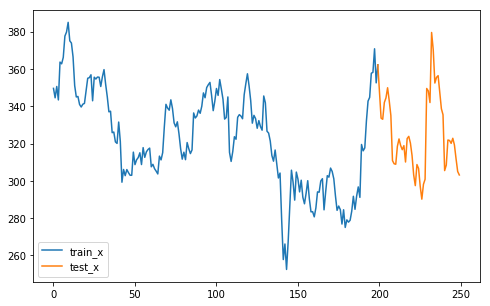

In [31]:
lx=len(x)
trs=int(lx*.8)
train_x_plotting= x[:trs]
test_x_plotting= x[trs:]

# Prepare data for plotting.
p_tx=list(train_x_plotting[:, 3])+[None]*(len(test_x_plotting))
p_ttx=([None]*(len(train_x_plotting)-1))+list(train_x_plotting[:, 3])[-1:]+list(test_x_plotting[:, 3])

# Plot closing prices for each day.
pyplot.figure(figsize=(8,5))
pyplot.plot(p_tx, label='train_x')
pyplot.plot(p_ttx, label='test_x')
pyplot.legend()
pyplot.show()

## Train

In [0]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM

import math
import os
import sys

name = 'default'
input_shape = train_x.shape[1:]
epochs = 100
batches = 5 #We have to choose batch size can be divided by training set samples(200 in this case) AND testset samples (50 in this case)

model= Sequential()
model.add(LSTM(60, input_shape=input_shape, stateful=True, batch_input_shape=(batches, input_shape[0], input_shape[1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse','mape'])
history = model.fit(train_x,train_y,verbose=2,epochs=epochs, batch_size=batches, validation_data=(test_x, test_y), shuffle=False)

# save model
mname='models/model-%s-%d-%d' % (name, epochs, batches)
model.save(mname+'.h5')



In [35]:
train_score = model.evaluate(train_x,train_y, verbose=0,batch_size=batches)
trainscore = 'RMSE: $%s MAPE: %.0f%%' % ("{:,.0f}".format(math.sqrt(train_score[0])),train_score[2])
print('Train Score: %s' % trainscore)

print()
test_score = model.evaluate(test_x, test_y, verbose=0, batch_size=batches)
tscore='RMSE: $%s MAPE: %.0f%%' % ("{:,.0f}".format(math.sqrt(test_score[0])), test_score[2])
print('Test Score: %s' % tscore)

Train Score: RMSE: $269 MAPE: 83%

Test Score: RMSE: $270 MAPE: 83%


In [36]:
test_score

[72820.37265625, 72820.37265625, 82.90941162109375]

In [42]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_percentage_error', 'loss', 'mean_squared_error', 'mean_absolute_percentage_error'])

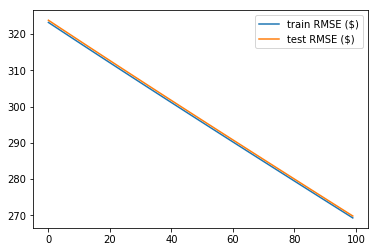

In [43]:
pyplot.plot([ math.sqrt(l) for l in history.history['loss'] ], label='train RMSE ($)')
pyplot.plot([ math.sqrt(l) for l in history.history['val_loss'] ], label='test RMSE ($)')
pyplot.legend()
pyplot.show()

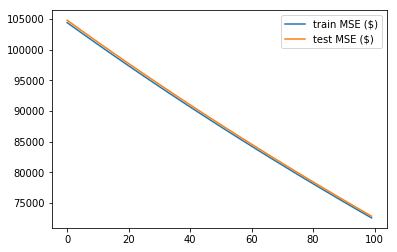

In [45]:
pyplot.plot([l for l in history.history['mean_squared_error'] ], label='train MSE ($)')
pyplot.plot([l for l in history.history['val_mean_squared_error'] ], label='test MSE ($)')
pyplot.legend()
pyplot.show()

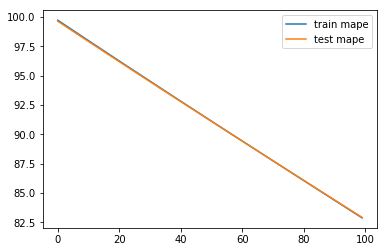

In [44]:
pyplot.plot(history.history['mean_absolute_percentage_error'], label='train mape')
pyplot.plot(history.history['val_mean_absolute_percentage_error'], label='test mape')
pyplot.legend()
pyplot.show()


### Look like we need to train the model more (more epochs or more layers in the model) because the rmse or mape still decreases, not yet convergence.

## Predict

In [58]:
from keras.models import Sequential, load_model

name = 'default'
input_shape = train_x.shape[1:]
epochs = 205
batches = 1 

mname='models/model-%s-%d-%d.h5' % (name, epochs, batches)

# Load a better model
if os.path.exists(mname):
  model=load_model(mname)
  print('Model loaded!')
else:
  print("Can't find %s model, train it first using 'train.py %s %d %d'" % (mname, name, epochs, batches))


to_predict=[[296.94,298.19,288.00,288.95,8350500], 280.74]
p=np.array(to_predict[0])
p=np.reshape(p,(batches,input_shape[0], input_shape[1])) # same as when we create LSTM layer

# true price
c=to_predict[0][1]

x=model.predict(p,batch_size=batches)

# We have just one prediction.
x=x[0][0]
print('Predicted $%.2f, actual $%.2f, error $%.2f (%.2f%%)' % (x, c, x-c, abs((x-c)*100/c)))



Model loaded!


ValueError: ignored

In [51]:
to_predict=[[296.94,298.19,288.00,288.95,8350500], 280.74]
p=np.array(to_predict[0])
p

array([2.9694e+02, 2.9819e+02, 2.8800e+02, 2.8895e+02, 8.3505e+06])

In [54]:
np.reshape(p,(1,input_shape[0], input_shape[1]))

array([[[2.9694e+02, 2.9819e+02, 2.8800e+02, 2.8895e+02, 8.3505e+06]]])

In [55]:
np.reshape(p,(1,input_shape[0], input_shape[1])).shape

(1, 1, 5)